## Importing Libraries

In [425]:
from __future__ import division
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # for plotting graphs
import seaborn as sns # for plotting graphs
import datetime as dt
import warnings
warnings.filterwarnings('ignore')
#import libraries
from datetime import datetime, timedelta,date
%matplotlib inline
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.cluster import KMeans

import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score, train_test_split

# Data Preparation

## Loading the data

In [426]:
data = pd.read_csv('shop_data_cerebri.csv')

In [427]:
data.head()

,Unnamed: 0,id,chain,dept,category,company,brand,date,productsize,productmeasure,purchasequantity,purchaseamount
0,0,86246,205,7,707,1078778070,12564.0,2012-03-02,12.0,OZ,1.0,7.59
1,1,86246,205,63,6319,107654575,17876.0,2012-03-02,64.0,OZ,1.0,1.59
2,2,86246,205,97,9753,1022027929,0.0,2012-03-02,1.0,CT,1.0,5.99
3,3,86246,205,25,2509,107996777,31373.0,2012-03-02,16.0,OZ,1.0,1.99
4,4,86246,205,55,5555,107684070,32094.0,2012-03-02,16.0,OZ,2.0,10.38


In [428]:
df = data

In [429]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1150000 entries, 0 to 1149999
Data columns (total 12 columns):
Unnamed: 0          1150000 non-null int64
id                  1150000 non-null int64
chain               1150000 non-null int64
dept                1150000 non-null int64
category            1150000 non-null int64
company             1150000 non-null int64
brand               1072497 non-null float64
date                1150000 non-null object
productsize         1150000 non-null float64
productmeasure      1135067 non-null object
purchasequantity    1149948 non-null float64
purchaseamount      1149697 non-null float64
dtypes: float64(4), int64(6), object(2)
memory usage: 105.3+ MB


In [430]:
#Removing rows with no customer ID
data= data[pd.notnull(data['id'])]

## Preprocessing the data

In [431]:
CATEGORICAL_FEATURES = ['chain', 'dept', 'category', 'brand', 'productmeasure']
NUMERIC_FEATURES = ['log_calibration_value']

ALL_FEATURES = CATEGORICAL_FEATURES + NUMERIC_FEATURES

In [432]:
def preprocess(df):
    df = df.query('purchaseamount>0')
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
    #df['start_date'] = df.groupby('id')['date'].transform('min')
    #df['end_date'] = df.groupby('id')['date'].transform('max')

    # Specify data types
    df['chain'] = (df['chain'].astype('category'))
    df['dept'] = (df['dept'].astype('category'))
    df['brand'] = (df['brand'].astype('category'))
    df['category'] = (df['category'].astype('category'))
    
    return df

In [433]:
data = preprocess(df)

In [434]:
data.head()

,Unnamed: 0,id,chain,dept,category,company,brand,date,productsize,productmeasure,purchasequantity,purchaseamount
0,0,86246,205,7,707,1078778070,12564.0,2012-03-02,12.0,OZ,1.0,7.59
1,1,86246,205,63,6319,107654575,17876.0,2012-03-02,64.0,OZ,1.0,1.59
2,2,86246,205,97,9753,1022027929,0.0,2012-03-02,1.0,CT,1.0,5.99
3,3,86246,205,25,2509,107996777,31373.0,2012-03-02,16.0,OZ,1.0,1.99
4,4,86246,205,55,5555,107684070,32094.0,2012-03-02,16.0,OZ,2.0,10.38


## Customer Segmentation

We use the <b> RFM </b> Recency-Frequency-Monetary method to segment our customers into 3 groups :

<p><b>Low Value:</b> Customers who are less active than others, not very frequent buyer/visitor and generates very low - zero - maybe negative revenue.
<p><b>Mid Value:</b> In the middle of everything. Often using our platform (but not as much as our High Values), fairly frequent and generates moderate revenue.
<p><b>High Value:</b> The group we don’t want to lose. High Revenue, Frequency and low Inactivity.
    <p> We will take data of 2011, calculate RFM and use it for predicting next year. So we need to create two dataframes first and append RFM scores to them.


In [435]:
data['date'].min(), data['date'].max()

(Timestamp('2012-03-02 00:00:00'), Timestamp('2013-07-23 00:00:00'))

In [436]:
#create 2012 and 2013 dataframes
df2012 = data[(data.date < date(2013,1,1))].reset_index(drop=True)
df2013 = data[(data.date >= date(2013,1,1)) ].reset_index(drop=True)

In [437]:
#create user dataframe for assigning clustering
user = pd.DataFrame(df2012['id'].unique())
user.columns = ['id']

In [438]:
#order cluster method
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

We came use of K-Means clustering to segment the customers into high, medium, or low value and to calculate the respective RFM.

In [439]:
#calculate recency score
max_purchase = df2012.groupby('id').date.max().reset_index()
max_purchase.columns = ['id','MaxPurchaseDate']
max_purchase['Recency'] = (max_purchase['MaxPurchaseDate'].max() - max_purchase['MaxPurchaseDate']).dt.days
user = pd.merge(user, max_purchase[['id','Recency']], on='id')

kmeans = KMeans(n_clusters=4)
kmeans.fit(user[['Recency']])
user['RecencyCluster'] = kmeans.predict(user[['Recency']])

user = order_cluster('RecencyCluster', 'Recency',user,False)

In [440]:
#calcuate frequency score
frequency = df2012.groupby('id').date.count().reset_index()
frequency.columns = ['id','Frequency']
user = pd.merge(user, frequency, on='id')

kmeans = KMeans(n_clusters=4)
kmeans.fit(user[['Frequency']])
user['FrequencyCluster'] = kmeans.predict(user[['Frequency']])

user = order_cluster('FrequencyCluster', 'Frequency',user,True)


In [441]:
#calcuate revenue score
df2012['Revenue'] = df2012['purchasequantity'] * df2012['purchaseamount']
revenue = df2012.groupby('id').Revenue.sum().reset_index()
user = pd.merge(user, revenue, on='id')

kmeans = KMeans(n_clusters=4)
kmeans.fit(user[['Revenue']])
user['RevenueCluster'] = kmeans.predict(user[['Revenue']])
user = order_cluster('RevenueCluster', 'Revenue',user,True)


In [442]:
#overall scoring
user['OverallScore'] = user['RecencyCluster'] + user['FrequencyCluster'] + user['RevenueCluster']
user['Segment'] = 'Low-Value'
user.loc[user['OverallScore']>2,'Segment'] = 'Mid-Value' 
user.loc[user['OverallScore']>4,'Segment'] = 'High-Value' 

In [443]:
user.head()

,id,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment
0,86246,0,3,4350,3,28208.35,3,9,High-Value
1,86252,0,3,4950,3,31395.90,3,9,High-Value
2,67957375,6,3,879,1,27614.09,3,7,High-Value
3,96664186,7,3,688,1,23906.39,3,7,High-Value
4,96648193,6,3,103,0,62244.69,3,6,High-Value


## Calculation of Life Time Value of customers for 2013

Since no cost is specified to acquire the customer, we consider revenue as the life time value

In [444]:
#calculate revenue and create a new dataframe for it
df2013['Revenue'] = df2013['purchasequantity'] * df2013['purchaseamount']
user_2013 = df2013.groupby('id')['Revenue'].sum().reset_index()
user_2013.columns = ['id','2013_Revenue']

We now merge our 2012 and 2013 dataframes and see how the revenues are affected in one year and figure out the change in customer behavior

In [445]:
merge = pd.merge(user, user_2013, on='id', how='left')
merge = merge.fillna(0)

In [446]:
merge.head()

,id,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment,2013_Revenue
0,86246,0,3,4350,3,28208.35,3,9,High-Value,61278.58
1,86252,0,3,4950,3,31395.90,3,9,High-Value,73187.73
2,67957375,6,3,879,1,27614.09,3,7,High-Value,3805.94
3,96664186,7,3,688,1,23906.39,3,7,High-Value,3783.07
4,96648193,6,3,103,0,62244.69,3,6,High-Value,142125.54


We now use K-Means clustering to classify our customers to 3 segments:
<li> Low LTV</li>
    <li>Medium LTV</li>
   <li>High LTV</li>

In [447]:
#remove outliers
merge = merge[merge['2013_Revenue']<merge['2013_Revenue'].quantile(0.99)]


#creating 3 clusters
kmeans = KMeans(n_clusters=3)
kmeans.fit(merge[['2013_Revenue']])
merge['LTVCluster'] = kmeans.predict(merge[['2013_Revenue']])

#order cluster number based on LTV
merge = order_cluster('LTVCluster', '2013_Revenue',merge,True)

#creatinga new cluster dataframe
cluster = merge.copy()

#see details of the clusters
cluster.groupby('LTVCluster')['2013_Revenue'].describe()

,count,mean,std,min,25%,50%,75%,max
LTVCluster,,,,,,,,
0,691.0,1001.485456,516.606750,0.00,569.470,980.46,1428.6900,1971.55
1,366.0,2941.647978,665.798628,1976.76,2338.945,2812.24,3474.8625,4394.53
2,135.0,5853.103852,1289.119058,4416.74,4924.100,5413.27,6398.8550,9790.13


Cluster 2 is best with mean LTV 5853 and cluster 0 is worst with mean LTV 1001

## Feature Engineering

We perform some steps to bring the data good enough to run our machine learning model on it and split the train and test data

In [448]:
#convert categorical columns to numerical
tx_class = pd.get_dummies(cluster)

#create X and y, X will be feature set and y is the label - LTV
X = tx_class.drop(['LTVCluster','2013_Revenue'],axis=1)
y = tx_class['LTVCluster']

#split training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state=123)

Segment is a categorical column that gets split to 0 and 1 notation 

In [449]:
X_train.head()

,id,Recency,RecencyCluster,Frequency,FrequencyCluster,Revenue,RevenueCluster,OverallScore,Segment_High-Value,Segment_Low-Value,Segment_Mid-Value
177,57426577,1,3,776,1,4327.21,1,5,1,0,0
252,93765042,1,3,711,1,4713.27,1,5,1,0,0
792,83679506,0,3,496,0,2221.05,0,3,0,0,1
304,75747032,7,3,423,0,4317.03,1,4,0,0,1
595,97177041,8,2,613,1,3252.98,0,3,0,0,1


In [450]:
#calculate and show correlations
corr_matrix = tx_class.corr()
corr_matrix['LTVCluster'].sort_values(ascending=False)

LTVCluster            1.000000
2013_Revenue          0.909347
Revenue               0.667950
RevenueCluster        0.661062
OverallScore          0.646195
Frequency             0.622719
FrequencyCluster      0.602065
Segment_High-Value    0.584978
RecencyCluster        0.188703
id                    0.037084
Recency              -0.154482
Segment_Low-Value    -0.288449
Segment_Mid-Value    -0.348633
Name: LTVCluster, dtype: float64

We see that the 2013 revenue with the 2012 RFM values are highly correlated to model our data

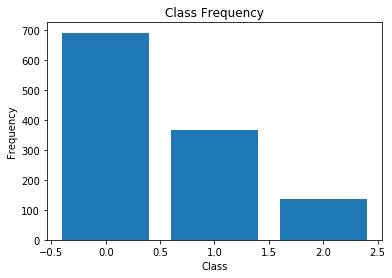

In [451]:
classes = y
unique, counts = np.unique(classes, return_counts=True)

plt.bar(unique,counts)
plt.title('Class Frequency')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

The above plot shows that the classes are imbalanced

# Modeling the Data

I will start with XGBoost multiclass classifier to test the predictions of the data because of its speed  and regularized approach to take the most suitable variables


In [475]:
#XGBoost Multiclassification Model
ltv_xgb_model = xgb.XGBClassifier(max_depth=5, learning_rate=0.1, gamma = 0 , objective= 'multi:softprob',
                                  min_child_weight = 1, scale_pos_weight = 1
                                  ,n_jobs=-1).fit(X_train, y_train)

print('Accuracy of XGB classifier on training set: {:.2f}'
       .format(ltv_xgb_model.score(X_train, y_train)))
print('Accuracy of XGB classifier on test set: {:.2f}'
       .format(ltv_xgb_model.score(X_test, y_test)))

y_pred = ltv_xgb_model.predict(X_test)
print(classification_report(y_test, y_pred))

Accuracy of XGB classifier on training set: 0.90
Accuracy of XGB classifier on test set: 0.80
              precision    recall  f1-score   support

           0       0.89      0.91      0.90        35
           1       0.65      0.69      0.67        16
           2       0.71      0.56      0.63         9

    accuracy                           0.80        60
   macro avg       0.75      0.72      0.73        60
weighted avg       0.80      0.80      0.80        60



# Improving Model Performance

## Scaling the training set

This is done to rescale the values to mean 0 and unit variance

In [454]:
features_train = X_train
features_test = X_test
target_train = y_train
target_test = y_test

from sklearn.preprocessing import StandardScaler
# Create scale object
scaler = StandardScaler()
# Fit scaler to training data only
scaler_fit = scaler.fit(features_train)
# Transform both train and test data with the trained scaler
X_train = scaler_fit.transform(features_train)
X_test = scaler_fit.transform(features_test)

## Implementing Baseline Model

In [480]:
import xgboost as xgb
# Create XGB Classifier object
xgb_clf = xgb.XGBClassifier(objective = "multi:softmax")
# Fit model
xgb_model = xgb_clf.fit(X_train, target_train)
# Predictions
y_train_preds = xgb_model.predict(X_train)
y_test_preds = xgb_model.predict(X_test)
# Print F1 scores and Accuracy
#print("Training F1 Micro Average: ", f1_score(target_train, y_train_preds, average = "micro"))
print("Test F1 Micro Average: ", f1_score(target_test, y_test_preds, average = "micro"))
print("Test Accuracy: ", accuracy_score(target_test, y_test_preds))

Test F1 Micro Average:  0.8000000000000002
Test Accuracy:  0.8


## Tuning the hyperparameters to improve model performance

In [481]:
# Create XGB Classifier object
xgb_clf = xgb.XGBClassifier(tree_method = "exact", predictor = "cpu_predictor", verbosity = 1,
                            objective = "multi:softmax")

# Create parameter grid
parameters = {"learning_rate": [0.1, 0.01, 0.001],
               "gamma" : [0.01, 0.1, 0.3, 0.5, 1, 1.5, 2],
               "max_depth": [2, 4, 7, 10],
               "colsample_bytree": [0.3, 0.6, 0.8, 1.0],
               "subsample": [0.2, 0.4, 0.5, 0.6, 0.7],
               "reg_alpha": [0, 0.5, 1],
               "reg_lambda": [1, 1.5, 2, 3, 4.5],
               "min_child_weight": [1, 3, 5, 7],
               "n_estimators": [100, 250, 500, 1000]}

from sklearn.model_selection import RandomizedSearchCV
# Create RandomizedSearchCV Object
xgb_rscv = RandomizedSearchCV(xgb_clf, param_distributions = parameters, scoring = "f1_micro",
                             cv = 10, verbose = 3, random_state = 40 )

# Fit the model
model_xgboost = xgb_rscv.fit(X_train, target_train)

# Model best estimators
print("Learning Rate: ", model_xgboost.best_estimator_.get_params()["learning_rate"])
print("Gamma: ", model_xgboost.best_estimator_.get_params()["gamma"])
print("Max Depth: ", model_xgboost.best_estimator_.get_params()["max_depth"])
print("Subsample: ", model_xgboost.best_estimator_.get_params()["subsample"])
print("Max Features at Split: ", model_xgboost.best_estimator_.get_params()["colsample_bytree"])
print("Alpha: ", model_xgboost.best_estimator_.get_params()["reg_alpha"])
print("Lamda: ", model_xgboost.best_estimator_.get_params()["reg_lambda"])
print("Minimum Sum of the Instance Weight Hessian to Make a Child: ",
      model_xgboost.best_estimator_.get_params()["min_child_weight"])
print("Number of Trees: ", model_xgboost.best_estimator_.get_params()["n_estimators"])

Fitting 10 folds for each of 10 candidates, totalling 100 fits
[CV] subsample=0.6, reg_lambda=1, reg_alpha=0, n_estimators=100, min_child_weight=5, max_depth=2, learning_rate=0.1, gamma=1.5, colsample_bytree=1.0 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  subsample=0.6, reg_lambda=1, reg_alpha=0, n_estimators=100, min_child_weight=5, max_depth=2, learning_rate=0.1, gamma=1.5, colsample_bytree=1.0, score=0.675, total=   0.4s
[CV] subsample=0.6, reg_lambda=1, reg_alpha=0, n_estimators=100, min_child_weight=5, max_depth=2, learning_rate=0.1, gamma=1.5, colsample_bytree=1.0 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s


[CV]  subsample=0.6, reg_lambda=1, reg_alpha=0, n_estimators=100, min_child_weight=5, max_depth=2, learning_rate=0.1, gamma=1.5, colsample_bytree=1.0, score=0.781, total=   0.4s
[CV] subsample=0.6, reg_lambda=1, reg_alpha=0, n_estimators=100, min_child_weight=5, max_depth=2, learning_rate=0.1, gamma=1.5, colsample_bytree=1.0 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.8s remaining:    0.0s


[CV]  subsample=0.6, reg_lambda=1, reg_alpha=0, n_estimators=100, min_child_weight=5, max_depth=2, learning_rate=0.1, gamma=1.5, colsample_bytree=1.0, score=0.728, total=   0.4s
[CV] subsample=0.6, reg_lambda=1, reg_alpha=0, n_estimators=100, min_child_weight=5, max_depth=2, learning_rate=0.1, gamma=1.5, colsample_bytree=1.0 
[CV]  subsample=0.6, reg_lambda=1, reg_alpha=0, n_estimators=100, min_child_weight=5, max_depth=2, learning_rate=0.1, gamma=1.5, colsample_bytree=1.0, score=0.684, total=   0.4s
[CV] subsample=0.6, reg_lambda=1, reg_alpha=0, n_estimators=100, min_child_weight=5, max_depth=2, learning_rate=0.1, gamma=1.5, colsample_bytree=1.0 
[CV]  subsample=0.6, reg_lambda=1, reg_alpha=0, n_estimators=100, min_child_weight=5, max_depth=2, learning_rate=0.1, gamma=1.5, colsample_bytree=1.0, score=0.754, total=   0.4s
[CV] subsample=0.6, reg_lambda=1, reg_alpha=0, n_estimators=100, min_child_weight=5, max_depth=2, learning_rate=0.1, gamma=1.5, colsample_bytree=1.0 
[CV]  subsample=

[CV]  subsample=0.2, reg_lambda=4.5, reg_alpha=0.5, n_estimators=250, min_child_weight=1, max_depth=2, learning_rate=0.001, gamma=0.5, colsample_bytree=1.0, score=0.688, total=   0.9s
[CV] subsample=0.2, reg_lambda=4.5, reg_alpha=0.5, n_estimators=250, min_child_weight=1, max_depth=2, learning_rate=0.001, gamma=0.5, colsample_bytree=1.0 
[CV]  subsample=0.2, reg_lambda=4.5, reg_alpha=0.5, n_estimators=250, min_child_weight=1, max_depth=2, learning_rate=0.001, gamma=0.5, colsample_bytree=1.0, score=0.759, total=   0.9s
[CV] subsample=0.2, reg_lambda=4.5, reg_alpha=0.5, n_estimators=250, min_child_weight=1, max_depth=2, learning_rate=0.001, gamma=0.5, colsample_bytree=1.0 
[CV]  subsample=0.2, reg_lambda=4.5, reg_alpha=0.5, n_estimators=250, min_child_weight=1, max_depth=2, learning_rate=0.001, gamma=0.5, colsample_bytree=1.0, score=0.696, total=   0.9s
[CV] subsample=0.7, reg_lambda=1, reg_alpha=0, n_estimators=100, min_child_weight=7, max_depth=4, learning_rate=0.1, gamma=0.1, colsampl

[CV]  subsample=0.7, reg_lambda=3, reg_alpha=1, n_estimators=100, min_child_weight=3, max_depth=10, learning_rate=0.001, gamma=0.01, colsample_bytree=0.6, score=0.693, total=   0.6s
[CV] subsample=0.7, reg_lambda=3, reg_alpha=1, n_estimators=100, min_child_weight=3, max_depth=10, learning_rate=0.001, gamma=0.01, colsample_bytree=0.6 
[CV]  subsample=0.7, reg_lambda=3, reg_alpha=1, n_estimators=100, min_child_weight=3, max_depth=10, learning_rate=0.001, gamma=0.01, colsample_bytree=0.6, score=0.649, total=   0.6s
[CV] subsample=0.7, reg_lambda=3, reg_alpha=1, n_estimators=100, min_child_weight=3, max_depth=10, learning_rate=0.001, gamma=0.01, colsample_bytree=0.6 
[CV]  subsample=0.7, reg_lambda=3, reg_alpha=1, n_estimators=100, min_child_weight=3, max_depth=10, learning_rate=0.001, gamma=0.01, colsample_bytree=0.6, score=0.746, total=   0.6s
[CV] subsample=0.7, reg_lambda=3, reg_alpha=1, n_estimators=100, min_child_weight=3, max_depth=10, learning_rate=0.001, gamma=0.01, colsample_bytr

[CV]  subsample=0.4, reg_lambda=1.5, reg_alpha=0, n_estimators=1000, min_child_weight=1, max_depth=7, learning_rate=0.01, gamma=0.3, colsample_bytree=0.6, score=0.679, total=   6.6s
[CV] subsample=0.4, reg_lambda=1.5, reg_alpha=0, n_estimators=1000, min_child_weight=1, max_depth=7, learning_rate=0.01, gamma=0.3, colsample_bytree=0.6 
[CV]  subsample=0.4, reg_lambda=1.5, reg_alpha=0, n_estimators=1000, min_child_weight=1, max_depth=7, learning_rate=0.01, gamma=0.3, colsample_bytree=0.6, score=0.723, total=   6.6s
[CV] subsample=0.4, reg_lambda=1.5, reg_alpha=0, n_estimators=1000, min_child_weight=1, max_depth=7, learning_rate=0.01, gamma=0.3, colsample_bytree=0.6 
[CV]  subsample=0.4, reg_lambda=1.5, reg_alpha=0, n_estimators=1000, min_child_weight=1, max_depth=7, learning_rate=0.01, gamma=0.3, colsample_bytree=0.6, score=0.616, total=   6.7s
[CV] subsample=0.7, reg_lambda=3, reg_alpha=0, n_estimators=250, min_child_weight=7, max_depth=10, learning_rate=0.01, gamma=0.3, colsample_bytree

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  3.0min finished


Learning Rate:  0.01
Gamma:  2
Max Depth:  2
Subsample:  0.4
Max Features at Split:  0.8
Alpha:  1
Lamda:  4.5
Minimum Sum of the Instance Weight Hessian to Make a Child:  1
Number of Trees:  100


In [485]:
xgb_clf = xgb.XGBClassifier(objective = "multi:softmax", learning_rate = 0.01, gamma = 2, max_depth = 2, subsample = 0.4,
                           colsample_bytree = 0.8, reg_alpha = 1, reg_lambda = 4.5, min_child_weight = 1, n_estimators = 100
                           ).fit(X_train, y_train) 
# Fit model
xgb_model = xgb_clf.fit(X_train, target_train)
# Predictions
y_train_preds = xgb_model.predict(X_train)


y_test_preds = xgb_model.predict(X_test)
# Print F1 scores and Accuracy
#print("Training F1 Micro Average: ", f1_score(target_train, y_train_preds, average = "micro"))
print("Test F1 Micro Average: ", f1_score(target_test, y_test_preds, average = "micro"))
print("Test Accuracy: ", accuracy_score(target_test, y_test_preds))

Test F1 Micro Average:  0.8166666666666667
Test Accuracy:  0.8166666666666667


We see slight improvement in test accuracy with tuning the hyperparameters

# How does this model help Big Mega accomplish their goal of increasing sales profit?

The above model with 82% test accuracy shows that we Big Mega can predict the type of customers who are their best customers in terms of Recency, Frequency, and Monetary value.

<li><b>High Value:</b> These customers make purchases frequently with higher amounts. They can be targeted with loyalty programs to incentivize them to shop more and fulfilling shopping experience</li>
<li><b>Medium Value:</b> These shoppers have made moderately frequent and medium value purchases and can be targeted by providing them with offers and coupons to incentivize them to shop more with Big Mega </li>
<li><b>Low Value:</b> These are cheap customers who come very less frequently and Big Mega can avoiding spending too much money in bringing these shoppers in as they aren't adding much value to the store. Infact they may have negative revenue that harms the business as the customer acquisition cost of these customers is higher than the value they provide </li>

# Do you think this data is appropriate for the objective?  What other data, if any, would you request from Big Mega?

The data that was provided helped me successfully complete the objective of predicting the Life Time Value of a customer.
<p> However, if I was provided with the Offers data by Big Mega, I could see how does the offer along with customer spending data affect the model. I could then pinpoint whether a particular offer is helping increase the LTV of high value customers and whether offers can lure Medium level customers more to drive the LTV up for these customers.